In [54]:
import torch
from enum import Enum

from torchvision.io import read_image
from torchvision import transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

import matplotlib.pyplot as plt
import numpy as np

from hiera import hiera_base_224, Hiera

device='cuda'
dtype=torch.float32

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model declaration

464x464 bc image is scaled to 465 but needs to be divisble

patch size for kernel + stride (non overlapping kernel=stride)

In [77]:
from timm.layers import resample_patch_embed, resample_abs_pos_embed

def load_network(net, pretrained_dir, gpu):
    antialias = True
    pretrained = torch.load(pretrained_dir,
                            map_location=device)
    
    print(pretrained.keys())
    if 'state_dict' in pretrained.keys():
        pretrained_dict = pretrained['state_dict']
    elif 'model_state' in pretrained.keys():
        pretrained_dict = pretrained['model_state']
    else:
        pretrained_dict = pretrained
    model_dict = net.state_dict()
    pretrained_dict_update = {}
    pretrained_dict_remove = []
    for k, v in pretrained_dict.items():
        if 'patch_embed.proj.weight' in k:
            O, I, H, W = model.patch_embed.proj.weight.shape
            if len(v.shape) < 4:
                # For old models that I trained prior to conv based patchification
                O, I, H, W = model.patch_embed.proj.weight.shape
                v = v.reshape(O, -1, H, W)
                if v.shape[-1] != W or v.shape[-2] != H:
                    v = resample_patch_embed(
                        v,
                        (H, W),
                        interpolation='bicubic',
                        antialias=antialias,
                        verbose=True,
                    )
            elif k == 'pos_embed' and v.shape[1] != model.pos_embed.shape[1]:
                # To resize pos embedding when using model at different size from pretrained weights
                num_prefix_tokens = 0 if getattr(model, 'no_embed_class', False) else getattr(model, 'num_prefix_tokens', 1)
                v = resample_abs_pos_embed(
                    v,
                    new_size=model.patch_embed.grid_size,
                    num_prefix_tokens=num_prefix_tokens,
                    interpolation=interpolation,
                    antialias=antialias,
                    verbose=True,
                )
            if k in model_dict:
                pretrained_dict_update[k] = v
            elif k[:7] == 'module.':
                if k[7:] in model_dict:
                    pretrained_dict_update[k[7:]] = v
            else:
                print("removing:", k)
                pretrained_dict_remove.append(k)
    print(pretrained_dict_update.keys())
    model_dict.update(pretrained_dict_update)
    net.load_state_dict(model_dict, strict=False)
    del (pretrained)
    return net.cuda(gpu), pretrained_dict_remove

In [71]:
model2 = Hiera(input_size=(464, 464))

[116, 116]
pos embed: 13456 96


## load_network works with exact sizes, doesn't like interpolating to fit new size

In [72]:
model2, _ = load_network(model2, '../aot-benchmark/pretrain_models/hiera_base_224.pth', 0)

dict_keys(['epoch', 'model_state', 'optimizer_state', 'scaler_state'])
dict_keys(['patch_embed.proj.weight'])


In [15]:
x = torch.rand(1, 3, 224, 224).to(device)
y = torch.rand(1, 3, 512, 512).to(device)

In [ ]:
out, intermediates = model2(y, return_intermediates=True)

In [70]:
for i in intermediates:
    print(i.shape)

torch.Size([1, 56, 56, 96])
torch.Size([1, 28, 28, 192])
torch.Size([1, 14, 14, 384])
torch.Size([1, 7, 7, 768])


## Works when we simply torch load it 

Need to interpolate everything?

Upsample to expect 256 images

In [44]:
model3 = Hiera()

checkpoint = torch.load('../aot-benchmark/pretrain_models/hiera_base_224.pth')

model_dict = checkpoint['model_state']
model3.load_state_dict(model_dict, strict=False)

[56, 56]
pos embed: 3136 96


<All keys matched successfully>

In [46]:
model3 = model3.to(device)

In [51]:
out, intermediates = model3(x, return_intermediates=True)

came fromelse
torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
came fromelse


In [52]:
for i in intermediates:
    print(i.shape)

torch.Size([1, 56, 56, 96])
torch.Size([1, 28, 28, 192])
torch.Size([1, 14, 14, 384])
torch.Size([1, 7, 7, 768])


## Loading pretrained model from hiera docs

In [23]:
from hiera_utils import pretrained_model

In [24]:
checkpoints = {
    "example_checkpoint": "https://dl.fbaipublicfiles.com/hiera/hiera_base_224.pth"
}

@pretrained_model(checkpoints, default="example_checkpoint")
def create_hiera_model():
    return Hiera(input_size=(512,512), num_classes=10)

In [25]:
model4 = create_hiera_model()

[128, 128]
Stage ends: [1, 4, 20, 23]
pos embed: 16384 96


In [26]:
model4 = model4.to(device)

In [28]:
intermedaites = model4(y)

came fromelse
torch.Size([1, 16384, 96])
torch.Size([1, 16384, 96])
came fromelse
X shape: torch.Size([1, 16384, 96])
Strides in schedule: (2, 2)
Curr size: [64, 64]
New shape: [1, 64, 2, 64, 2, 96]
Strides in schedule: (2, 2)
Curr size: [32, 32]
New shape: [4, 32, 2, 32, 2, 96]
Strides in schedule: (2, 2)
Curr size: [16, 16]
New shape: [16, 16, 2, 16, 2, 96]


In [20]:
model5 = Hiera(input_size=(512,512)).to(device)

[128, 128]
Stage ends: [1, 4, 20, 23]
pos embed: 16384 96


## Failing unroll

N = 13456 = 464 * 29 (which is patch_size = 16 * 29 = 464) which will be divided by 4
N// 4 = 3364 which sqrt = 58

This doesn't work because we are unrolling the thing several times

Eventaully we do 29 // 2 which loses values for us

Design choice, scale up even further to 512

In [21]:
intermediates = model5(y, return_intermediates=True)

came fromelse
torch.Size([1, 16384, 96])
torch.Size([1, 16384, 96])
came fromelse
X shape: torch.Size([1, 16384, 96])
Strides in schedule: (2, 2)
Curr size: [64, 64]
New shape: [1, 64, 2, 64, 2, 96]
Strides in schedule: (2, 2)
Curr size: [32, 32]
New shape: [4, 32, 2, 32, 2, 96]
Strides in schedule: (2, 2)
Curr size: [16, 16]
New shape: [16, 16, 2, 16, 2, 96]
torch.Size([1, 128, 128, 96])
torch.Size([1, 64, 64, 192])
torch.Size([1, 32, 32, 384])
torch.Size([1, 16, 16, 768])


In [29]:
for i in intermediates:
    print(i.shape)

torch.Size([1, 128, 128, 96])
torch.Size([1, 64, 64, 192])
torch.Size([1, 32, 32, 384])
torch.Size([1, 16, 16, 768])


In [32]:
img = read_image('../AttentionEval/assets/tree_frog.jpg')

In [60]:
transform = transforms.Compose([transforms.Resize((512,512)),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

In [61]:
sample = transform(img.to(dtype)) / 255.

In [62]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
def imgnet_vis(img, grad=True):
    # if uses grad, detach
    if grad:
        image = img.squeeze(0).permute(1, 2, 0).detach()
    else:
        image = img.squeeze(0).permute(1, 2, 0)
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.axis('off')
    return

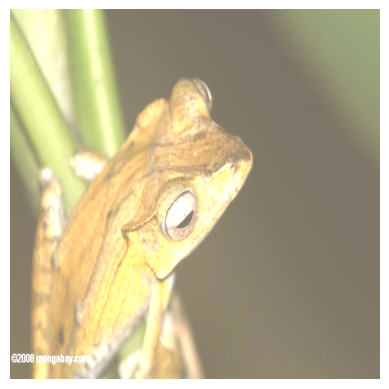

In [63]:
imgnet_vis(sample)

In [66]:
sample = sample.to(device)
sample = sample.unsqueeze(0)
sample.shape

torch.Size([1, 3, 512, 512])

In [71]:
intermediates = model4(sample, return_intermediates=True)

came fromelse
torch.Size([1, 16384, 96])
torch.Size([1, 16384, 96])
came fromelse
X shape: torch.Size([1, 16384, 96])
Strides in schedule: (2, 2)
Curr size: [64, 64]
New shape: [1, 64, 2, 64, 2, 96]
Strides in schedule: (2, 2)
Curr size: [32, 32]
New shape: [4, 32, 2, 32, 2, 96]
Strides in schedule: (2, 2)
Curr size: [16, 16]
New shape: [16, 16, 2, 16, 2, 96]


In [72]:
for i in intermediates:
    print(i.shape)

torch.Size([1, 128, 128, 96])
torch.Size([1, 64, 64, 192])
torch.Size([1, 32, 32, 384])
torch.Size([1, 16, 16, 768])
